In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx

In [2]:
from torch_geometric.datasets import TUDataset


In [3]:
dataset = TUDataset(root='./graph/TUDataset', name='MUTAG')
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


Extracting graph\TUDataset\MUTAG\MUTAG.zip
Processing...
Done!


In [4]:
data = dataset[0]
print(data)
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [5]:
torch.manual_seed(12345)
dataset = dataset.shuffle()   
train_dataset = dataset[:150] 
test_dataset = dataset[150:]  
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [8]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
for step, data in enumerate(train_loader):
    print(f'step{step + 1}:')
    print('=======')
    print(f'一批內含圖形的個數: {data.num_graphs}')
    print(data)


step1:
一批內含圖形的個數: 64
DataBatch(edge_index=[2, 2564], x=[1159, 7], edge_attr=[2564, 4], y=[64], batch=[1159], ptr=[65])
step2:
一批內含圖形的個數: 64
DataBatch(edge_index=[2, 2594], x=[1174, 7], edge_attr=[2594, 4], y=[64], batch=[1174], ptr=[65])
step3:
一批內含圖形的個數: 22
DataBatch(edge_index=[2, 836], x=[381, 7], edge_attr=[836, 4], y=[22], batch=[381], ptr=[23])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [15]:
import numpy as np
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch) 
        loss = criterion(out, data.y) 
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad() 

In [16]:
def test(loader):
    model.eval()
    correct = 0
    pred_all = np.array([])
    actual_all = np.array([])
    for data in loader:  
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)                
        correct += int((pred == data.y).sum())  
        correct_ratio = correct / len(loader.dataset)        
        pred_all = np.concatenate((pred_all, pred.cpu().numpy()))
        actual_all = np.concatenate((actual_all, data.y.cpu().numpy()))
    return correct_ratio, pred_all, actual_all

In [17]:
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, 訓練準確率: {train_acc[0]:.4f}, ' +
          f'測試準確率: {test_acc[0]:.4f}')

Epoch: 001, 訓練準確率: 0.6467, 測試準確率: 0.7368
Epoch: 002, 訓練準確率: 0.6467, 測試準確率: 0.7368
Epoch: 003, 訓練準確率: 0.6467, 測試準確率: 0.7368
Epoch: 004, 訓練準確率: 0.6467, 測試準確率: 0.7368
Epoch: 005, 訓練準確率: 0.6467, 測試準確率: 0.7368
Epoch: 006, 訓練準確率: 0.7200, 測試準確率: 0.7632
Epoch: 007, 訓練準確率: 0.7333, 測試準確率: 0.8158
Epoch: 008, 訓練準確率: 0.7200, 測試準確率: 0.7632
Epoch: 009, 訓練準確率: 0.7133, 測試準確率: 0.7632
Epoch: 010, 訓練準確率: 0.7267, 測試準確率: 0.7632
Epoch: 011, 訓練準確率: 0.7200, 測試準確率: 0.7895
Epoch: 012, 訓練準確率: 0.7200, 測試準確率: 0.7895
Epoch: 013, 訓練準確率: 0.7067, 測試準確率: 0.8158
Epoch: 014, 訓練準確率: 0.7400, 測試準確率: 0.7632
Epoch: 015, 訓練準確率: 0.7400, 測試準確率: 0.7895
Epoch: 016, 訓練準確率: 0.7133, 測試準確率: 0.8684
Epoch: 017, 訓練準確率: 0.7533, 測試準確率: 0.7895
Epoch: 018, 訓練準確率: 0.7467, 測試準確率: 0.7895
Epoch: 019, 訓練準確率: 0.7467, 測試準確率: 0.7895
Epoch: 020, 訓練準確率: 0.7533, 測試準確率: 0.7368
Epoch: 021, 訓練準確率: 0.7267, 測試準確率: 0.8421
Epoch: 022, 訓練準確率: 0.7267, 測試準確率: 0.8421
Epoch: 023, 訓練準確率: 0.7467, 測試準確率: 0.7368
Epoch: 024, 訓練準確率: 0.7533, 測試準確率: 0.7632
Epoch: 025, 訓練準確

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_acc[2], test_acc[1])

array([[ 4,  6],
       [ 2, 26]], dtype=int64)

C:\Users\ian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


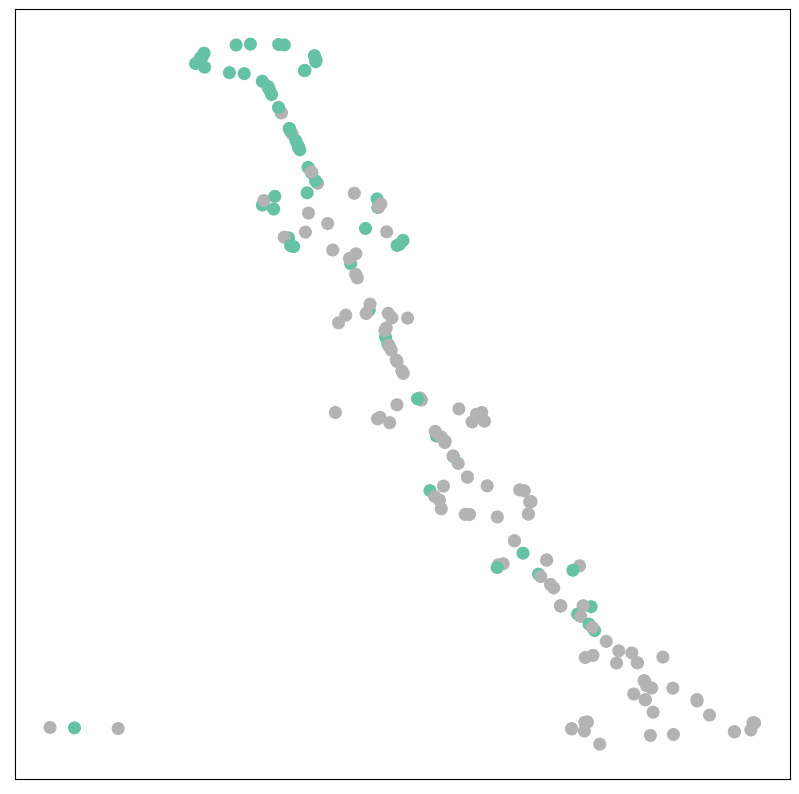

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
test_loader_all = DataLoader(dataset[:], batch_size=len(dataset), shuffle=False)
for data in test_loader_all:  
    data = data.to(device)
    out = model(data.x, data.edge_index, data.batch)  
    pred = out.argmax(dim=1)           

visualize(out.cpu(), color=data.cpu().y)